# Best case optimization

## In general
- **Goal:** predict the theoretical limit of embedding dimension  
- **Best case:** optimize both query and document embeddings directly $\implies$ no limit from natural language $\implies$ free embeddings  
- Any constraints on the best-case scenario necessarily apply to all real-world scenarios  
- The QREL matrix was given previously

## Original Experiment Settings
- **Training set:**
    - $n$ document embeddings, dimension $d$ (controlled)
    - $m$ query vectors, dimension $d$
    - Only top-$k$ relevant docs per query marked in QREL
    - Max distinct query results: $m = \binom{n}{k}$
    - Shared top-$k$ results $\implies k(n-k)$ redundant inequalities $\implies$ duplicated rows in $A$
    - $A$ constructed by enumerating all top-$k$ cases
- **Loss:** InfoNCE without negatives  
$$
L_\text{total} = -\frac{1}{M} \sum_{i=1}^m \sum_{d_r \in R_i} 
\log \frac{\exp(\text{sim}(q_i, d_r)/\tau)}
{\sum_{d_k \in D} \exp(\text{sim}(q_i, d_k)/\tau)}
$$
  - $R_i = \{ d_r \in D \mid d_r \text{ relevant to } q_i \}$, $k=2$
- **Optimizer:** SGD or Adam (Adam preferred)
- **Normalization:** after each update
- **Early stopping:** no improvement in next 1000 iterations
- **Scaling:** for fixed $d$, increase $n$ until 100% accuracy is unreachable

## Training

We use the largest freely available GPU setup on Kaggle for training, with a custom PyTorch model.

In [1]:
!nvidia-smi

Tue Jan 20 17:32:23 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Loss Function
- **As mentioned in the paper (footnote):**  
$$
L_\text{total} = -\frac{1}{M} \sum_{i=1}^M 
\log \frac{\sum_{d_r \in R_i} \exp(\text{sim}(q_i, d_r)/\tau)}
{\sum_{d_k \in D} \exp(\text{sim}(q_i, d_k)/\tau)}
$$
where:  
  - $R_i = \{ d_r \in D \mid d_r \text{ relevant to query } q_i \}$  
  - $D$ = set of documents  
  - $k := 2$ (for simplicity)  
- **As used in [Google's implementation](https://github.com/google-deepmind/limit/blob/main/code/free_embedding_experiment.py):**  
$$
L_\text{total} = -\frac{1}{M} \sum_{i=1}^m \sum_{d_r \in R_i} 
\log \frac{\exp(\text{sim}(q_i, d_r)/\tau)}{\sum_{d_k \in D} \exp(\text{sim}(q_i, d_k)/\tau)}
$$
- From the source code, $M$ is the number of positive query-doc pairs (i.e., the number of ones in the QREL matrix) and the second loss function is the correct one.

In [2]:
import numpy as np
from itertools import combinations
import torch

class FreeEmbeddingsModel(torch.nn.Module):
    def __init__(self, num_of_docs: int, dimension: int, k: int = 2, temp: float = 0.07):
        super().__init__()

        self.__n = num_of_docs
        self.__d = dimension
        self.__k = k
        self.__temp = temp
        self.__m = None
        self.docs = None
        self.queries = None
        self.__qrel_matrix = None

        self.__qrel_matrix = self.__generate_qrel_matrix(self.__n, self.__k)
        self.__m = self.__qrel_matrix.shape[0]

        self.docs = torch.nn.Parameter(torch.randn(self.__n, self.__d))
        self.queries = torch.nn.Parameter(torch.randn(self.__m, self.__d))
        with torch.no_grad():
            self.queries.div_(self.queries.norm(dim=1, keepdim=True))
            self.docs.div_(self.docs.norm(dim=1, keepdim=True))

    @staticmethod
    def __generate_qrel_matrix(n: int, k: int) -> torch.Tensor:
        combos = list(combinations(range(n), k))
        matrix = torch.zeros((len(combos), n), dtype=torch.int)
        for i, combo in enumerate(combos):
            matrix[i, list(combo)] = 1
        return matrix

    # the loss function from their implementation
    # it results a cubic d-critical_n curve, which is below the expected one
    def forward(self):
        self.__qrel_matrix = self.__qrel_matrix.to(self.docs.device)

        queries_norm = self.queries
        docs_norm = self.docs

        logits = (queries_norm @ docs_norm.T) / self.__temp
        log_probs = torch.log_softmax(logits, dim=1)

        sum_pos_log_probs = (log_probs * self.__qrel_matrix).sum()
        M = self.__qrel_matrix.sum()
        total_loss = -sum_pos_log_probs / M
        return total_loss

    def accuracy(self) -> float:
        docs_norm = self.docs / self.docs.norm(dim=1, keepdim=True)
        queries_norm = self.queries / self.queries.norm(dim=1, keepdim=True)

        sim = queries_norm @ docs_norm.T
        similar_rows = 0
        for i in range(self.__m):
            # use masking to avoid ties
            top_k_mask = self.__qrel_matrix[i].bool()

            pos_vals = sim[i][top_k_mask]
            neg_vals = sim[i][~top_k_mask]

            if pos_vals.numel() == 0 or neg_vals.numel() == 0:
                continue

            similar_rows += int(torch.min(pos_vals) >= torch.max(neg_vals))

        return similar_rows / self.__m

In [ ]:
# params from the original experiment
DEFAULT_EXPERIMENT_PARAMS: Dict[str, Any] = {
    "q": None,
    "learning_rate": 0.01,
    "num_iterations": 100000,
    "temperature": 0.1,
    "seed": 42,
    "show_progress": True,
    "device": "gpu",
    "log_interval": 50,
    "early_stopping_patience": 1000,
    "early_stopping_min_delta": 0.00001,
    "early_stopping_monitor_metric": "loss",
    "early_stopping_restore_best_weights": False,
}

In [3]:
import torch

def train(
    num_of_docs: int,
    dimension: int,
    max_patience: int = 1000,
    temp: float = 0.1,
    learning_rate: float = 0.01,
    max_iters: int = 100000,
    min_delta: float = 0.00001
) -> float:
    min_loss = torch.finfo(torch.float32).max
    max_acc = -1
    best_query_weights = None
    best_doc_weights = None

    device = torch.device("cuda")
    model = FreeEmbeddingsModel(num_of_docs=num_of_docs, dimension=dimension, temp=temp).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    prev_loss = torch.finfo(torch.float32).max
    iters = 0
    patience = 0
    while max_patience > patience and iters < max_iters:
        optimizer.zero_grad()
        loss = model()

        if min_loss - loss > min_delta:
            min_loss = loss
            best_query_weights = model.queries.detach().clone()
            best_doc_weights = model.docs.detach().clone()
            patience = 0
        else:
            patience += 1

        if iters % 1000 == 0:
            accuracy = model.accuracy()
            print(f"[docs={num_of_docs}, dim={dimension}]: epoch #{iters}, patience: {patience}/{max_patience}, accuracy={accuracy}, loss={loss}")
            if accuracy >= 1.0:
                return 1.0

        loss.backward()
        optimizer.step()

        # Normalize the embeddings for numerical stability
        with torch.no_grad():
            model.queries.div_(model.queries.norm(dim=1, keepdim=True))
            model.docs.div_(model.docs.norm(dim=1, keepdim=True))

        iters += 1

    with torch.no_grad():
        model.queries.copy_(best_query_weights)
        model.docs.copy_(best_doc_weights)

    return model.accuracy()

In [ ]:
pred = lambda d: -10.5322 + 4.0309*d + 0.0520*d**2 + 0.0037*d**3
pred(15)

74.1188

In [5]:
import math

def find_critical_num_of_docs(dimension: int) -> int:
    is_accurate = dict()

    product = 5
    while train(num_of_docs=int(product), dimension=dimension) >= 1:
        product *= 1.5

    lower = int(product / 1.5)
    upper = int(product)

    while lower <= upper:
        middle = (lower + upper) // 2

        is_mid_acc = is_accurate.get(middle)
        if is_mid_acc is None:
            is_mid_acc = train(num_of_docs=middle, dimension=dimension) >= 1
            is_accurate[middle] = is_mid_acc

        if not is_mid_acc and middle >= 1:
            is_prev_mid_acc = is_accurate.get(middle - 1)
            if is_prev_mid_acc is None:
                is_prev_mid_acc = train(num_of_docs=middle - 1, dimension=dimension) >= 1
                is_accurate[middle - 1] = is_prev_mid_acc

            if is_prev_mid_acc:
                return middle

        if is_mid_acc:
            lower = middle + 1
        else:
            upper = middle - 1

    return lower

In [6]:
critical_n = []
for d in range(9, 31):
    critical_n.append(find_critical_num_of_docs(d))

[docs=5, dim=9]: epoch #0, patience: 0/1000, accuracy=0.1, loss=3.9339427947998047
[docs=5, dim=9]: epoch #1000, patience: 4/1000, accuracy=1.0, loss=0.693740963935852
[docs=7, dim=9]: epoch #0, patience: 0/1000, accuracy=0.047619047619047616, loss=4.259016990661621
[docs=7, dim=9]: epoch #1000, patience: 4/1000, accuracy=1.0, loss=0.6943049430847168
[docs=11, dim=9]: epoch #0, patience: 0/1000, accuracy=0.0, loss=5.735230922698975
[docs=11, dim=9]: epoch #1000, patience: 0/1000, accuracy=1.0, loss=0.7003893852233887
[docs=16, dim=9]: epoch #0, patience: 0/1000, accuracy=0.016666666666666666, loss=6.2918009757995605
[docs=16, dim=9]: epoch #1000, patience: 0/1000, accuracy=1.0, loss=0.7252538800239563
[docs=25, dim=9]: epoch #0, patience: 0/1000, accuracy=0.0033333333333333335, loss=6.733804702758789
[docs=25, dim=9]: epoch #1000, patience: 0/1000, accuracy=1.0, loss=0.8393248319625854
[docs=37, dim=9]: epoch #0, patience: 0/1000, accuracy=0.0, loss=7.365826606750488
[docs=37, dim=9]: 

In [7]:
critical_n

[35,
 37,
 41,
 50,
 56,
 61,
 68,
 77,
 85,
 89,
 106,
 118,
 121,
 136,
 143,
 151,
 169,
 180,
 196,
 221,
 227,
 243]

## Results evaluation

We evaluate the previously achieved critical-$n$ values by comparing them to the resulting cubic regressions.

In [1]:
# previously generated critical_n-s
critical_n = [35,
 37,
 41,
 50,
 56,
 61,
 68,
 77,
 85,
 89,
 106,
 118,
 121,
 136,
 143,
 151,
 169,
 180,
 196,
 221,
 227,
 243]

cubic regression
          3           2
0.003866 x + 0.06175 x + 2.84 x - 0.4842
original cubic regression
        3         2
0.0037 x + 0.052 x + 4.031 x - 10.53


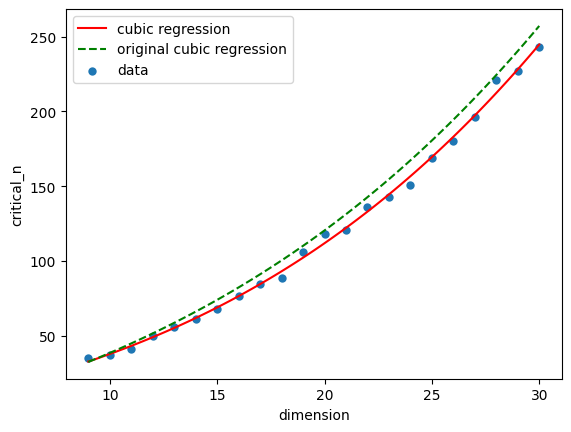

In [3]:
from matplotlib import pyplot as plt
import numpy as np

x = list(range(9, 31))
y = critical_n

coeffs = np.polyfit(x, y, 3)
poly = np.poly1d(coeffs)
print("cubic regression")
print(poly)


original_coeffs = [0.0037, 0.0520, 4.0309, -10.5322]
original_poly = np.poly1d(original_coeffs)
print("original cubic regression")
print(original_poly)

plt.xlabel("dimension")
plt.ylabel("critical_n")

x_fit = np.linspace(min(x), max(x), 100)
y_fit = poly(x_fit)
plt.plot(x_fit, y_fit, color='red', label="cubic regression")

y_fit = original_poly(x_fit)
plt.plot(x_fit, y_fit, color='green', linestyle="--", label="original cubic regression")

plt.scatter(x, y, label="data", linewidth=0.001)

plt.legend()
plt.savefig("free_emb_res.pdf")
plt.show()

In [13]:
dimensions = [512, 768, 1024, 3072, 4096]

In [17]:
# prediction for the standard embedding dimensions
[f"{d:.3f}" for d in poly(dimensions)]

['536511.579', '1789790.790', '4218623.097', '112667580.779', '266709528.516']

In [18]:
[f"{d:.3f}" for d in original_poly(dimensions)]

['512290.370', '1709799.925', '4031487.810', '107769914.178', '255150979.189']

In [7]:
from sklearn.metrics import r2_score

r2_score(y, poly(x))

0.9975782651766453

The results are largely consistent, both in magnitude and when extrapolated to higher dimensions.

And the $R^2_\mathrm{reproduced} \approx 1 \implies$ the cubic regressions also fit the generated critical values very well.

In [10]:
import numpy as np

points = np.linspace(5, 32)
rsse = np.linalg.norm(poly(points) - original_poly(points))
rmse = np.sqrt(((poly(points) - original_poly(points))**2).mean())

print("RSSE:", rsse)
print("RMSE:", rmse)


RSSE: 58.287987794937756
RMSE: 8.243166286303842


The $\mathrm{RSSE}, \mathrm{RMSE}$ errors can be considered small on the magnitude scale.